In [1]:
import os
import cv2
import numpy as np
import string
import time
from tensorflow import keras
import tensorflow as tf
import tensorflow.keras.backend as K

In [2]:
os.chdir("/content/drive/MyDrive/Data_Sets/OCR")

In [3]:
!ls

mjsynth.tar.gz


In [ ]:
!tar -xvzf mjsynth.tar.gz

Streaming output truncated to the last 5000 lines.
mnt/ramdisk/max/90kDICT32px/2490/4/111_FREES_30779.jpg
mnt/ramdisk/max/90kDICT32px/2490/4/110_Dickering_21476.jpg
mnt/ramdisk/max/90kDICT32px/2490/4/109_Principality_60122.jpg
mnt/ramdisk/max/90kDICT32px/2490/4/108_Whale_86109.jpg
mnt/ramdisk/max/90kDICT32px/2490/4/107_Surplus_76473.jpg
mnt/ramdisk/max/90kDICT32px/2490/4/106_captors_11423.jpg
mnt/ramdisk/max/90kDICT32px/2490/4/105_betrothed_7245.jpg
mnt/ramdisk/max/90kDICT32px/2490/4/104_tarnished_77568.jpg
mnt/ramdisk/max/90kDICT32px/2490/4/103_SEMIVOWEL_69362.jpg
mnt/ramdisk/max/90kDICT32px/2490/4/102_croupy_18315.jpg
mnt/ramdisk/max/90kDICT32px/2490/4/101_INSISTS_39838.jpg
mnt/ramdisk/max/90kDICT32px/2490/4/100_BUMP_10188.jpg
mnt/ramdisk/max/90kDICT32px/2490/4/99_WHOPS_86449.jpg
mnt/ramdisk/max/90kDICT32px/2490/4/98_NESTLING_51347.jpg
mnt/ramdisk/max/90kDICT32px/2490/4/97_Sizing_71214.jpg
mnt/ramdisk/max/90kDICT32px/2490/4/96_toaster_79392.jpg
mnt/ramdisk/max/90kDICT32px/2490/4/95_H

In [3]:
char_list = string.ascii_letters+string.digits
print(char_list)
print(len(char_list))

abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789
62


In [4]:
# encoding each word into digits

def encode_to_labels(txt):
    out = []
    for index, char in enumerate(txt):
        try:
            out.append(char_list.index(char))
        except:
            print(char)

    return out

In [5]:
encode_to_labels("Pepsi")

[41, 4, 15, 18, 8]

In [7]:
path = '/content/drive/MyDrive/Data_Sets/OCR/mnt/ramdisk/max/90kDICT32px'


# lists for training dataset
training_img = []
training_txt = []
train_input_length = []
train_label_length = []
train_orig_txt = []

#lists for validation dataset
valid_img = []
valid_txt = []
valid_input_length = []
valid_label_length = []
valid_orig_txt = []

#lists for test dataset
test_img = []
test_txt = []
test_input_length = []
test_label_length = []
test_orig_txt = []

max_label_len = 0

i = 1
flag = 0

for root, dirnames, filenames in os.walk(path):
    # Check if filename ends with .jpg
    for f_name in filenames:
        if f_name.endswith('.jpg'):
            img = cv2.imread(os.path.join(root, f_name))
            # get the text label of image
            txt = f_name.split('_')[1]
            # compute maximum length of the text
            if len(txt) > max_label_len:
                max_label_len = len(txt)
            # split the 20000 data into train, validation by 90:10
            if i%10 == 0:
                valid_orig_txt.append(txt)
                valid_label_length.append(len(txt))
                valid_input_length.append(31)
                valid_img.append(img)
                valid_txt.append(encode_to_labels(txt))
            else:
                # convert each image to shape (32, 128, 1)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                img = cv2.resize(img, (128,32))
                img = np.expand_dims(img , axis = 2)
                # Normalize image
                img = img/255.
                train_orig_txt.append(txt)
                train_label_length.append(len(txt))
                train_input_length.append(31)
                training_img.append(img)
                training_txt.append(encode_to_labels(txt))
            # break the loop if total data is 50000
            if i == 50000:
                flag = 1
                break
            i+=1
    if flag == 1:
        break

In [8]:
# Take 25% of validation data for test
split_size = int(0.10*len(valid_orig_txt))

test_orig_txt = valid_orig_txt[:split_size]
test_label_length = valid_label_length[:split_size]
test_input_length = valid_input_length[:split_size]
test_img = valid_img[:split_size]
test_txt = valid_txt[:split_size]

valid_img = valid_img[split_size:]
valid_txt = valid_txt[split_size:]
valid_input_length = valid_input_length[split_size:]
valid_label_length = valid_label_length[split_size:]

In [9]:
print(len(training_img))
print(len(valid_img))
print(len(test_img))

45000
4500
500


In [10]:
# coverting images in valid_img
for idx, img in enumerate(valid_img):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img = cv2.resize(img, (128,32))
  img = np.expand_dims(img , axis = 2)
  valid_img[idx] = img/255.

In [11]:
# pad each output label to maximum text length
from keras.utils import pad_sequences

train_padded_txt = pad_sequences(training_txt, maxlen=max_label_len, padding='post', value = len(char_list))
valid_padded_txt = pad_sequences(valid_txt, maxlen=max_label_len, padding='post', value = len(char_list))

In [12]:
# Creating tensorflow dataset

train_dataset = tf.data.Dataset.from_tensor_slices(((training_img, train_padded_txt, train_input_length,
                                                    train_label_length), np.zeros(len(training_img))))
valid_dataset = tf.data.Dataset.from_tensor_slices(((valid_img, valid_padded_txt, valid_input_length,
                                                    valid_label_length), np.zeros(len(valid_img))))

# batch, and prefetch the datasets for better performance
batch_size = 32

train_dataset = train_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
valid_dataset = valid_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)


In [13]:
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)


def CRNN_Model():
  inputs = keras.layers.Input(shape=(32,128,1))
  x = keras.layers.Conv2D(64, (3,3), activation='relu', padding='same', name='conv_1')(inputs)
  x = keras.layers.MaxPooling2D(pool_size=(2,2), strides=2, name='pool_1')(x)
  x = keras.layers.Conv2D(128, (3,3), activation='relu', padding='same', name='conv_2')(x)
  x = keras.layers.MaxPooling2D(pool_size=(2,2), strides=2, name='pool_2')(x)
  x = keras.layers.Conv2D(256, (3,3), activation='relu', padding='same', name='conv_3')(x)
  x = keras.layers.Conv2D(256, (3,3), activation='relu', padding='same', name='conv_4')(x)
  # Rectangular pool window 2x1 to get wider feature map and shrink feature map accross height.
  x = keras.layers.MaxPooling2D(pool_size=(2,1), name='pool_3')(x)
  x = keras.layers.Conv2D(512, (3,3), activation='relu', padding='same', name='conv_5')(x)
  x = keras.layers.BatchNormalization(name='batch_norm_1')(x)
  x = keras.layers.Conv2D(512, (3,3), activation='relu', padding='same', name='conv_6')(x)
  x = keras.layers.BatchNormalization(name='batch_norm_2')(x)
  x = keras.layers.MaxPooling2D(pool_size=(2,1), name='pool_4')(x)
  x = keras.layers.Conv2D(512, (2,2), activation='relu')(x)

  # LSTM Block
  # Input: (31, 512)
  x = keras.layers.Lambda(lambda x: K.squeeze(x, 1), name='squeeze_input')(x)
  x = keras.layers.Bidirectional(keras.layers.LSTM(256, return_sequences=True, dropout=0.2), name='BiLSTM_1')(x)
  x = keras.layers.Bidirectional(keras.layers.LSTM(256, return_sequences=True, dropout=0.2), name='BiLSTM_2')(x)
  dense_output = keras.layers.Dense(len(char_list)+1, activation='softmax')(x)

  return inputs, dense_output, keras.models.Model(inputs=[inputs], outputs=dense_output)


In [14]:
K.clear_session()

inputs, output, crnn_model = CRNN_Model()

# CTC loss
labels = keras.layers.Input(name='the_labels', shape=[max_label_len], dtype='float32')
input_length = keras.layers.Input(name='input_length', shape=[1], dtype='int64')
label_length = keras.layers.Input(name='label_length', shape=[1], dtype='int64')
ctc_loss = keras.layers.Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([output, labels, input_length, label_length])

ctc_loss_model = keras.models.Model(inputs=[inputs, labels, input_length, label_length], outputs=ctc_loss)

crnn_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 32, 128, 1)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_1 (Conv2D)                      │ (None, 32, 128, 64)         │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_1 (MaxPooling2D)                │ (None, 16, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_2 (Conv2D)                      │ (None, 16, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_2 (MaxPooling2D)                │ (None, 8, 32, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_3 (Conv2D)                      │ (None, 8, 32, 256)          │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_4 (Conv2D)                      │ (None, 8, 32, 256)          │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_3 (MaxPooling2D)                │ (None, 4, 32, 256)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_5 (Conv2D)                      │ (None, 4, 32, 512)          │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_norm_1 (BatchNormalization)    │ (None, 4, 32, 512)          │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_6 (Conv2D)                      │ (None, 4, 32, 512)          │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_norm_2 (BatchNormalization)    │ (None, 4, 32, 512)          │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_4 (MaxPooling2D)                │ (None, 2, 32, 512)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 1, 31, 512)          │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ squeeze_input (Lambda)               │ (None, 31, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BiLSTM_1 (Bidirectional)             │ (None, 31, 512)             │       1,574,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BiLSTM_2 (Bidirectional)             │ (None, 31, 512)             │       1,574,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 31, 63)              │          32,319 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,735,039 (33.32 MB)

 Trainable params: 8,732,991 (33.31 MB)

 Non-trainable params: 2,048 (8.00 KB)

In [15]:
checkpoint = keras.callbacks.ModelCheckpoint(filepath='best_model.keras', monitor='val_loss',
                                              verbose=1, save_best_only=True, mode='auto')

ctc_loss_model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = 'adam')

In [16]:
# Modelcheckpoint callback
ctc_loss_model.fit(train_dataset,
                    validation_data=valid_dataset,
                    batch_size=32,
                    epochs=50,
                    callbacks=[checkpoint],
                    verbose=1)

Epoch 1/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 31.0962
Epoch 1: val_loss improved from inf to 30.65189, saving model to best_model.keras


/usr/local/lib/python3.11/dist-packages/keras/src/saving/serialization_lib.py:390: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized: ctc_loss_model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = 'adam')

  return {key: serialize_keras_object(value) for key, value in obj.items()}


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 60s 34ms/step - loss: 31.0954 - val_loss: 30.6519
Epoch 2/50
1405/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 27.5591
Epoch 2: val_loss improved from 30.65189 to 24.57853, saving model to best_model.keras
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 46s 33ms/step - loss: 27.5571 - val_loss: 24.5785
Epoch 3/50
1406/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 22.5246
Epoch 3: val_loss improved from 24.57853 to 14.85013, saving model to best_model.keras
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 46s 32ms/step - loss: 22.5208 - val_loss: 14.8501
Epoch 4/50
1406/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 11.5627
Epoch 4: val_loss improved from 14.85013 to 8.81729, saving model to best_model.keras
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 46s 32ms/step - loss: 11.5608 - val_loss: 8.8173
Epoch 5/50
1406/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 7.8144
Epoch 5: val_loss improved from 8.81729 to 7.05300, saving model to best_model.keras
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 46s 32ms/step - lo

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━

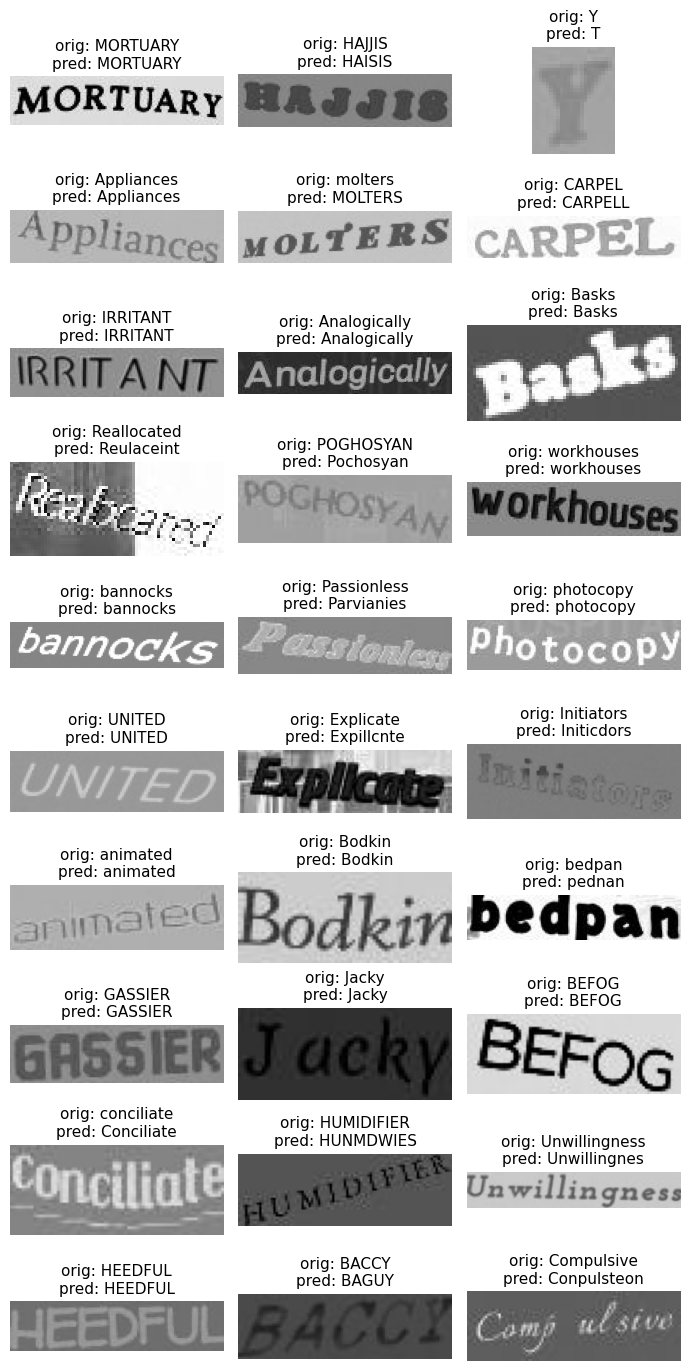

In [68]:
import matplotlib.pyplot as plt

crnn_model.load_weights('best_model.keras')

# Show 30 images in 10,3 grid
fig, axes = plt.subplots(10, 3, figsize=(7,14))

for i, img in enumerate(test_img[:30]):
    org_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (128,32))
    img = np.expand_dims(img , axis = 2)
    img = img/255.
    img = img.reshape(1, 32, 128, 1)
    prediction = crnn_model.predict(img)
    out = K.get_value(K.ctc_decode(prediction, input_length=np.ones(prediction.shape[0])*prediction.shape[1], greedy=True)[0][0])
    pred = ""
    for p in out[0]:
        if int(p) != -1:
            pred += char_list[int(p)]

    row = i // 3
    col = i % 3

    axes[row, col].set_title(f"orig: {test_orig_txt[i]}\npred: {pred}", fontsize=11)
    axes[row, col].imshow(org_img)
    axes[row, col].axis("off")

plt.tight_layout()
plt.show()